### 📦 第 0 格：导入必要的库
导入了如 `torch`, `cv2`, `numpy`, `matplotlib`, `tqdm`, `torchvision.transforms` 等用于图像处理、模型构建、训练可视化所需的基础包。

In [1]:
import os  
import cv2  
import torch  
import random  
import numpy as np 
import matplotlib.pyplot as plt  
from tqdm import tqdm
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### ⚙️ 第 1 格：超参数配置
定义模型名称、训练轮数、批大小、学习率、测试集比例等训练配置参数。

In [2]:
config = {  
    "model_name": "resnet", 
    "num_epochs": 15,
    "batch_size": 32,
    "learning_rate": 0.001,
    "test_size": 0.2,
    "sample_ratio": 1.0
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "Aerial_Landscapes/"

### 🧠 第 2 格：模型初始化函数
根据传入的模型名（resnet 或 vgg）初始化预训练模型并替换输出层以匹配数据集类别数。

In [3]:
def initialize_model(model_name, num_classes, use_pretrained=True):
    input_size = 224
    if model_name == "resnet":
        model = models.resnet18(pretrained=use_pretrained)  # 初始化 ResNet 模型
        model.fc = nn.Linear(model.fc.in_features, num_classes)  # 使用ResNet18
    elif model_name == "vgg":
        model = models.vgg16(pretrained=use_pretrained)  # 初始化 VGG 模型
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    else:
        raise ValueError("不支持的模型名称，请选择 'resnet' 或 'vgg'")
    return model, input_size

### 🧱 第 3 格：图像预处理流程
定义训练和测试图像所使用的图像增强与归一化操作，包括随机裁剪、缩放、标准化等。

In [4]:
def get_transforms(input_size=224):
    train_transform = transforms.Compose([  
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    test_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((input_size, input_size)),
        transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),  
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x + 0.05 * torch.randn_like(x)),  
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    test_transform = transforms.Compose([  
        transforms.ToPILImage(),
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return train_transform, test_transform

### 🗂️ 第 4 格：自定义 PyTorch 数据集类
用于将图像和标签组合为 Dataset 对象，以便后续使用 DataLoader 加载。

In [7]:
class CustomDataset(Dataset): 
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image, label

### 🧪 第 5 格：数据加载和划分函数
从指定文件夹加载图像数据，并按设定比例划分为训练集和测试集，同时返回类别标签映射。

In [8]:
def load_and_split_dataset(root_dir, test_size=0.2, sample_ratio=1.0):
    classes = sorted(os.listdir(root_dir))
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    train_images, train_labels = [], []
    test_images, test_labels = [], []

    for cls_name in classes:
        cls_path = os.path.join(root_dir, cls_name)
        img_files = [os.path.join(cls_path, f) for f in os.listdir(cls_path) if f.endswith('.jpg')]
        random.seed(42)
        random.shuffle(img_files)
        n_samples = int(len(img_files) * sample_ratio)
        split = int(n_samples * (1 - test_size))
        imgs = img_files[:n_samples]
        train_imgs = imgs[:split]
        test_imgs = imgs[split:]
        train_images.extend([cv2.imread(p) for p in train_imgs])
        train_labels.extend([class_to_idx[cls_name]] * len(train_imgs))
        test_images.extend([cv2.imread(p) for p in test_imgs])
        test_labels.extend([class_to_idx[cls_name]] * len(test_imgs))

    return (train_images, train_labels), (test_images, test_labels), classes

### 🔁 第 6 格：ResNet/VGG 训练函数
包括训练循环、Early Stopping、loss 和 acc 的记录，并在训练完成后绘制学习曲线图。

In [9]:
from tqdm import tqdm

def train_model(model, device, train_loader, test_loader, criterion, optimizer,  # 定义 ResNet/VGG 通用训练函数
                num_epochs=25, checkpoint_path='checkpoint.pth', patience=5):

    best_acc = 0.0
    epochs_no_improve = 0
    early_stop = False
    history = {
        'train_loss': [], 'train_acc': [],
        'test_loss': [], 'test_acc': []
    }

    for epoch in range(num_epochs):
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
        for batch in train_loader_tqdm:
            if early_stop:
                print(f"⚠️ 早停触发于第 {epoch+1} 轮")
                break

        model.train()
        train_loss, correct_train, total_train = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == labels.data)
            total_train += labels.size(0)

        epoch_train_loss = train_loss / total_train
        epoch_train_acc = correct_train.double() / total_train
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc.item())

        model.eval()
        test_loss, correct_test, total_test = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_test += torch.sum(preds == labels.data)
                total_test += labels.size(0)

        epoch_test_loss = test_loss / total_test
        epoch_test_acc = correct_test.double() / total_test
        history['test_loss'].append(epoch_test_loss)
        history['test_acc'].append(epoch_test_acc.item())

        print(f"Epoch {epoch+1}: Train Acc={epoch_train_acc:.4f}, Test Acc={epoch_test_acc:.4f}")

        if epoch_test_acc > best_acc:
            best_acc = epoch_test_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), checkpoint_path)
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                early_stop = True

    return model, history

### 📊 第 7 格：评估函数
对模型在测试集上的表现进行评估，生成预测值与真实值列表，可用于后续可视化。

In [10]:
def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels)
            y_pred.extend(preds.cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation='vertical', cmap='Blues')

### 🧪 第 8 格：加载数据集
调用数据加载函数并获取训练图像、测试图像、类别标签等信息。

/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [02:58<00:00, 262kB/s]
Epoch 1/15: 100%|██████████| 300/300 [00:15<00:00, 19.15batch/s]


Epoch 1: Train Acc=0.6674, Test Acc=0.8029


Epoch 2/15: 100%|██████████| 300/300 [00:15<00:00, 19.78batch/s]


Epoch 2: Train Acc=0.7610, Test Acc=0.8075


Epoch 3/15: 100%|██████████| 300/300 [00:14<00:00, 20.12batch/s]


Epoch 3: Train Acc=0.7997, Test Acc=0.8463


Epoch 4/15: 100%|██████████| 300/300 [00:14<00:00, 21.00batch/s]


Epoch 4: Train Acc=0.8224, Test Acc=0.8754


Epoch 5/15: 100%|██████████| 300/300 [00:14<00:00, 20.36batch/s]


Epoch 5: Train Acc=0.8305, Test Acc=0.8808


Epoch 6/15: 100%|██████████| 300/300 [00:17<00:00, 17.21batch/s]


Epoch 6: Train Acc=0.8443, Test Acc=0.8813


Epoch 7/15: 100%|██████████| 300/300 [00:14<00:00, 20.69batch/s]


Epoch 7: Train Acc=0.8493, Test Acc=0.9008


Epoch 8/15: 100%|██████████| 300/300 [00:14<00:00, 20.64batch/s]


Epoch 8: Train Acc=0.8576, Test Acc=0.8879


Epoch 9/15: 100%|██████████| 300/300 [00:16<00:00, 18.65batch/s]


Epoch 9: Train Acc=0.8648, Test Acc=0.9017


Epoch 10/15: 100%|██████████| 300/300 [00:15<00:00, 19.96batch/s]


Epoch 10: Train Acc=0.8698, Test Acc=0.8929


Epoch 11/15: 100%|██████████| 300/300 [00:14<00:00, 20.57batch/s]


Epoch 11: Train Acc=0.8735, Test Acc=0.8933


Epoch 12/15: 100%|██████████| 300/300 [00:14<00:00, 20.53batch/s]


Epoch 12: Train Acc=0.8822, Test Acc=0.9029


Epoch 13/15: 100%|██████████| 300/300 [00:14<00:00, 20.51batch/s]


Epoch 13: Train Acc=0.8854, Test Acc=0.9150


Epoch 14/15: 100%|██████████| 300/300 [00:14<00:00, 20.39batch/s]


Epoch 14: Train Acc=0.8888, Test Acc=0.9054


Epoch 15/15: 100%|██████████| 300/300 [00:14<00:00, 21.15batch/s]


Epoch 15: Train Acc=0.8856, Test Acc=0.9113
Evaluation Metrics (Precision, Recall, F1-score):

              precision    recall  f1-score   support

 Agriculture     0.8041    0.9750    0.8814       160
     Airport     0.8750    0.7438    0.8041       160
       Beach     0.9597    0.8938    0.9256       160
        City     0.9412    0.9000    0.9201       160
      Desert     0.9660    0.8875    0.9251       160
      Forest     0.9871    0.9563    0.9714       160
   Grassland     0.9605    0.9125    0.9359       160
     Highway     0.9701    0.8125    0.8844       160
        Lake     0.9112    0.9625    0.9362       160
    Mountain     0.9487    0.9250    0.9367       160
     Parking     0.9455    0.9750    0.9600       160
        Port     0.9405    0.9875    0.9634       160
     Railway     0.7387    0.9187    0.8189       160
 Residential     0.9290    0.9812    0.9544       160
       River     0.8701    0.8375    0.8535       160

    accuracy                         0.

<Figure size 1200x1000 with 0 Axes>

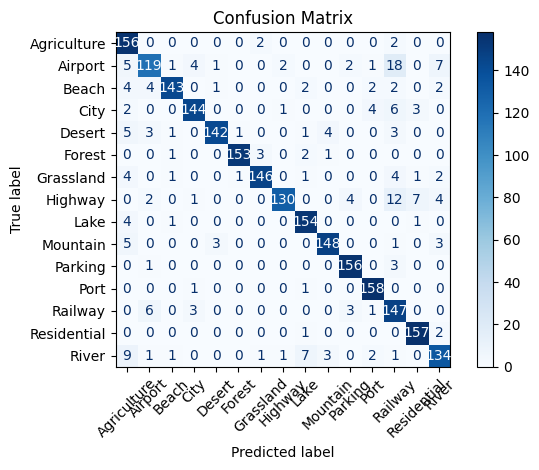

In [11]:
(train_images, train_labels), (test_images, test_labels), classes = load_and_split_dataset(
    dataset_path,
    test_size=config["test_size"],  # 设置模型训练的超参数
    sample_ratio=config["sample_ratio"]  # 设置模型训练的超参数
)

model, input_size = initialize_model(
    model_name=config["model_name"],  # 设置模型训练的超参数
    num_classes=len(classes),
    use_pretrained=True
)
model = model.to(device)

train_transform, test_transform = get_transforms(input_size)

train_dataset = CustomDataset(train_images, train_labels, train_transform)
test_dataset = CustomDataset(test_images, test_labels, test_transform)
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)  # 设置模型训练的超参数
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)  # 设置模型训练的超参数

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])  # 设置模型训练的超参数

model, history = train_model(
    model, device, train_loader, test_loader,
    criterion, optimizer,
    num_epochs=config["num_epochs"],  # 设置模型训练的超参数
    patience=5
)

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels)
        y_pred.extend(preds.cpu().numpy())

report = classification_report(y_true, y_pred, target_names=classes, digits=4)
print("Evaluation Metrics (Precision, Recall, F1-score):\n")
print(report)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
plt.figure(figsize=(12, 10))
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix for RESNET18")
plt.grid(False)
plt.tight_layout()
plt.show()

In [14]:
def train_vgg_model(model, device, train_loader, val_loader, criterion, optimizer, num_epochs=10):  # 定义 VGG 的独立训练函数
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):  # 加 tqdm 显示训练进度
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        train_losses.append(running_loss / len(train_loader))
        train_accs.append(correct / total)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_correct / val_total)

        print(f"[VGG] Epoch {epoch+1}/{num_epochs} - Train Acc: {train_accs[-1]:.4f} - Val Acc: {val_accs[-1]:.4f}")

    import matplotlib.pyplot as plt  # 导入库
    import numpy as np  # 导入库
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss", c="red")
    plt.plot(val_losses, label="Val Loss", c="blue")
    plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend(); plt.show()
    plt.figure(figsize=(10, 5))
    plt.plot(train_accs, label="Train Acc", c="orangered")
    plt.plot(val_accs, label="Val Acc", c="green")
    plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend(); plt.show()

/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [35:10<00:00, 262kB/s] 
Epoch 1/15: 100%|██████████| 300/300 [00:55<00:00,  5.38it/s]


[VGG] Epoch 1/15 - Train Acc: 0.2122 - Val Acc: 0.2387


Epoch 2/15: 100%|██████████| 300/300 [00:56<00:00,  5.34it/s]


[VGG] Epoch 2/15 - Train Acc: 0.3387 - Val Acc: 0.3400


Epoch 3/15: 100%|██████████| 300/300 [00:55<00:00,  5.38it/s]


[VGG] Epoch 3/15 - Train Acc: 0.3928 - Val Acc: 0.3371


Epoch 4/15: 100%|██████████| 300/300 [00:55<00:00,  5.36it/s]


[VGG] Epoch 4/15 - Train Acc: 0.4318 - Val Acc: 0.3771


Epoch 5/15: 100%|██████████| 300/300 [00:55<00:00,  5.38it/s]


[VGG] Epoch 5/15 - Train Acc: 0.4560 - Val Acc: 0.4692


Epoch 6/15: 100%|██████████| 300/300 [00:55<00:00,  5.38it/s]


[VGG] Epoch 6/15 - Train Acc: 0.4829 - Val Acc: 0.5042


Epoch 7/15: 100%|██████████| 300/300 [00:55<00:00,  5.38it/s]


[VGG] Epoch 7/15 - Train Acc: 0.5194 - Val Acc: 0.5542


Epoch 8/15: 100%|██████████| 300/300 [00:56<00:00,  5.28it/s]


[VGG] Epoch 8/15 - Train Acc: 0.5223 - Val Acc: 0.5667


Epoch 9/15: 100%|██████████| 300/300 [00:56<00:00,  5.34it/s]


[VGG] Epoch 9/15 - Train Acc: 0.5577 - Val Acc: 0.5746


Epoch 10/15: 100%|██████████| 300/300 [00:55<00:00,  5.39it/s]


[VGG] Epoch 10/15 - Train Acc: 0.5457 - Val Acc: 0.6083


Epoch 11/15: 100%|██████████| 300/300 [00:55<00:00,  5.38it/s]


[VGG] Epoch 11/15 - Train Acc: 0.5673 - Val Acc: 0.6379


Epoch 12/15: 100%|██████████| 300/300 [00:55<00:00,  5.37it/s]


[VGG] Epoch 12/15 - Train Acc: 0.5739 - Val Acc: 0.5663


Epoch 13/15: 100%|██████████| 300/300 [00:55<00:00,  5.36it/s]


[VGG] Epoch 13/15 - Train Acc: 0.5792 - Val Acc: 0.6217


Epoch 14/15: 100%|██████████| 300/300 [00:56<00:00,  5.35it/s]


[VGG] Epoch 14/15 - Train Acc: 0.5864 - Val Acc: 0.6379


Epoch 15/15: 100%|██████████| 300/300 [00:55<00:00,  5.38it/s]


[VGG] Epoch 15/15 - Train Acc: 0.5923 - Val Acc: 0.6342


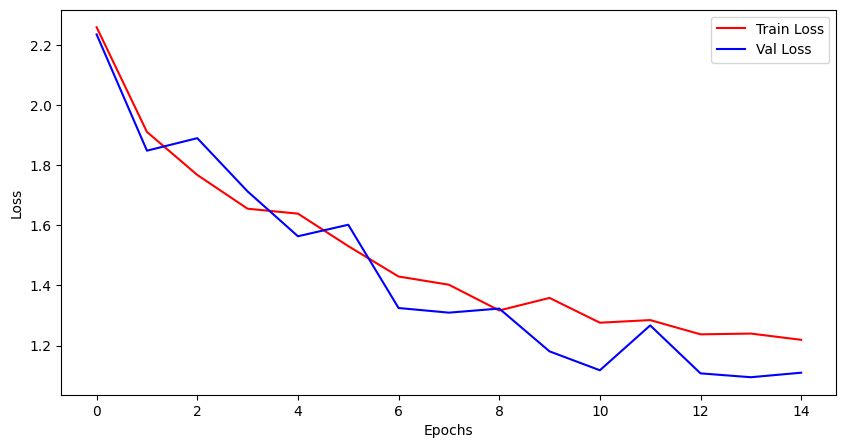

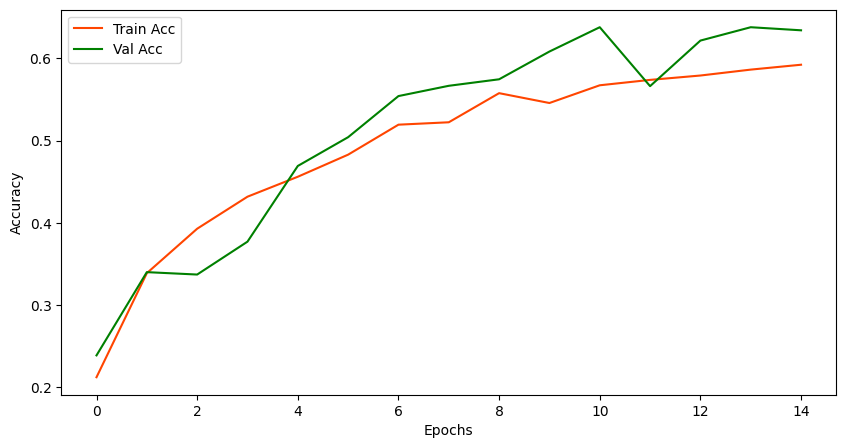

In [15]:
vgg_model = initialize_model("vgg", num_classes=len(classes))[0].to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg_model.parameters(), lr=config["learning_rate"])  # 设置模型训练的超参数

train_vgg_model(vgg_model, device, train_loader, test_loader, criterion, optimizer, num_epochs=config["num_epochs"]) # 设置模型训练的超参数


==================== VGG Evaluation Metrics ====================
              precision    recall  f1-score   support

 Agriculture       0.61      0.69      0.65       160
     Airport       0.49      0.27      0.35       160
       Beach       0.83      0.67      0.74       160
        City       0.56      0.46      0.51       160
      Desert       0.88      0.86      0.87       160
      Forest       0.80      0.81      0.80       160
   Grassland       0.65      0.95      0.77       160
     Highway       0.35      0.22      0.27       160
        Lake       0.90      0.74      0.81       160
    Mountain       0.42      0.61      0.49       160
     Parking       0.93      0.66      0.77       160
        Port       0.91      0.81      0.86       160
     Railway       0.38      0.46      0.42       160
 Residential       0.52      0.87      0.65       160
       River       0.51      0.44      0.48       160

    accuracy                           0.63      2400
   macro avg  

Text(0.5, 1.0, 'Confusion Matrix for VGG16')

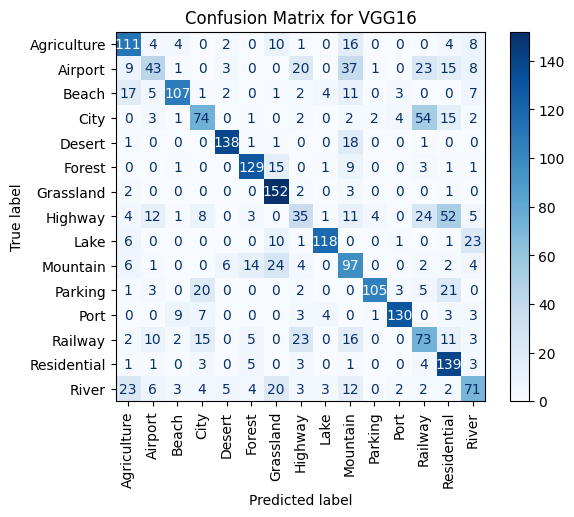

In [16]:
# ✅ 使用 evaluate_model 函数评估 VGG 模型分类表现
print("\n==================== VGG Evaluation Metrics ====================")
evaluate_model(vgg_model, test_loader, device, class_names=classes)
plt.title(f"Confusion Matrix for VGG16")

In [18]:
import os  # 导入库
import cv2  # 导入库
import torch  # 导入库
import numpy as np  # 导入库
import matplotlib.pyplot as plt  # 导入库
from collections import defaultdict
from torchcam.methods import GradCAM

def overlay_heatmap(img: np.ndarray, cam: np.ndarray, alpha: float = 0.5) -> np.ndarray:
    cam_uint8 = np.uint8(255 * cam)
    heatmap = cv2.applyColorMap(cam_uint8, cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    if img.max() > 1.0:
        img = np.float32(img) / 255
    if img.shape[:2] != heatmap.shape[:2]:
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    overlayed = heatmap * alpha + img
    overlayed = overlayed / np.max(overlayed)
    return np.uint8(255 * overlayed)

def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def apply_gradcam_all_classes(model, device, dataloader, model_name="resnet", save_dir="gradcam_outputs"):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()

    if model_name == "resnet":
        target_layer = model.layer4[-1].conv2
    elif model_name == "vgg":
        target_layer = model.features[-1]
    else:
        raise ValueError("Unsupported model")

    cam_extractor = GradCAM(model, target_layer=target_layer)

    seen_classes = defaultdict(int)
    total_target_classes = 15
    class_id_to_name = [
        "Agriculture", "Airport", "Beach", "City", "Desert", "Forest", "Grassland", "Highway",
        "Lake", "Mountain", "Parking", "Port", "Railway", "Residential", "River"
    ]

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)

        for i in range(inputs.shape[0]):
            label = labels[i].item()
            if seen_classes[label] >= 1:
                continue 

            img_tensor = inputs[i].unsqueeze(0)
            output = model(img_tensor)
            class_idx = torch.argmax(output).item()

            cam_tensor = cam_extractor(class_idx=class_idx, scores=output)[0]
            cam = cam_tensor.cpu().numpy()
            if cam.ndim == 3:
                cam = cam[0]
            cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

            unnorm_img_tensor = unnormalize(img_tensor.squeeze(0).cpu(),
                                            mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225])
            raw_image = np.clip(unnorm_img_tensor.permute(1, 2, 0).numpy(), 0, 1)

            cam = cv2.resize(cam, (raw_image.shape[1], raw_image.shape[0]))
            result = overlay_heatmap(raw_image, cam)
            result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

            orig_img = np.uint8(raw_image * 255)
            orig_bgr = cv2.cvtColor(orig_img, cv2.COLOR_RGB2BGR)
            result_bgr = cv2.cvtColor(result_rgb, cv2.COLOR_RGB2BGR)

            cname = class_id_to_name[label]
            cv2.imwrite(os.path.join(save_dir, f"{cname}_original.png"), orig_bgr)
            cv2.imwrite(os.path.join(save_dir, f"{cname}_gradcam.png"), result_bgr)
            cv2.imwrite(os.path.join(save_dir, f"{cname}_compare.png"), np.hstack((orig_bgr, result_bgr)))

            fig, axs = plt.subplots(1, 2, figsize=(10, 4))
            axs[0].imshow(orig_img)
            axs[0].set_title(f"{cname} - Original")
            axs[0].axis('off')
            axs[1].imshow(result_rgb)
            axs[1].set_title(f"{cname} - GradCAM (Pred: {class_id_to_name[class_idx]})")
            axs[1].axis('off')
            plt.tight_layout()
            plt.show()

            seen_classes[label] += 1

        if len(seen_classes) >= total_target_classes:
            print("✅ 已为所有类别生成 Grad-CAM 可视化。")
            break

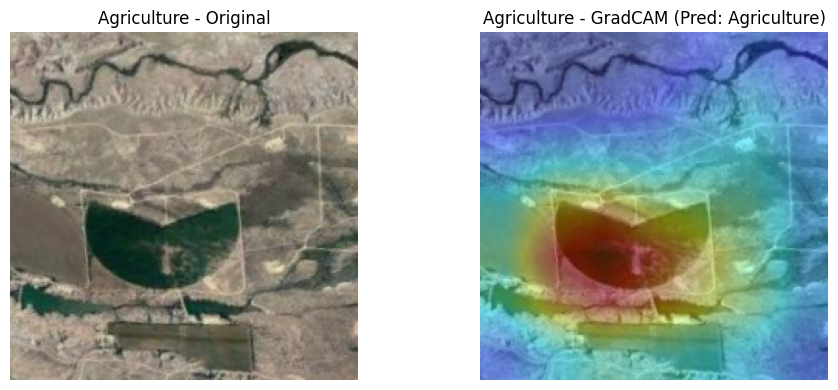

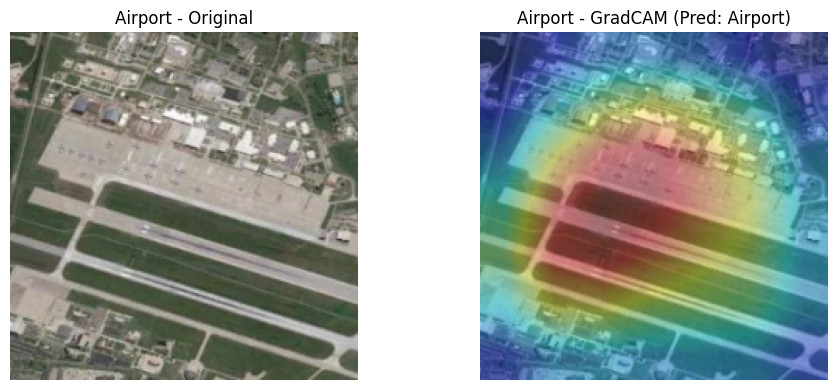

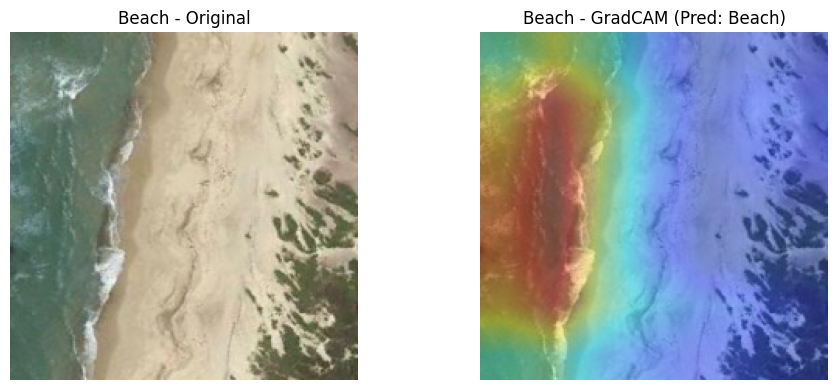

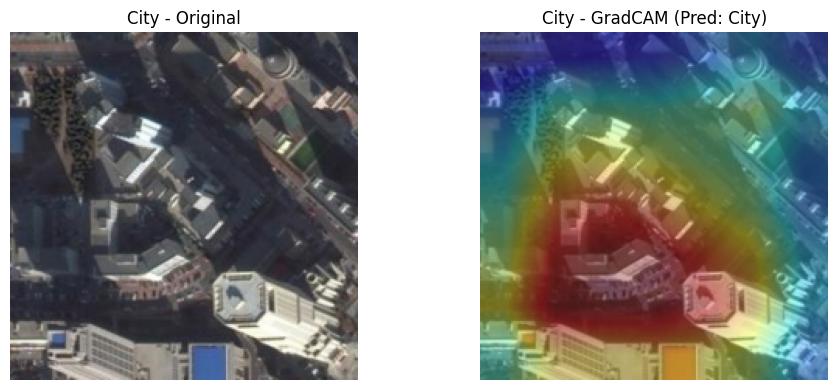

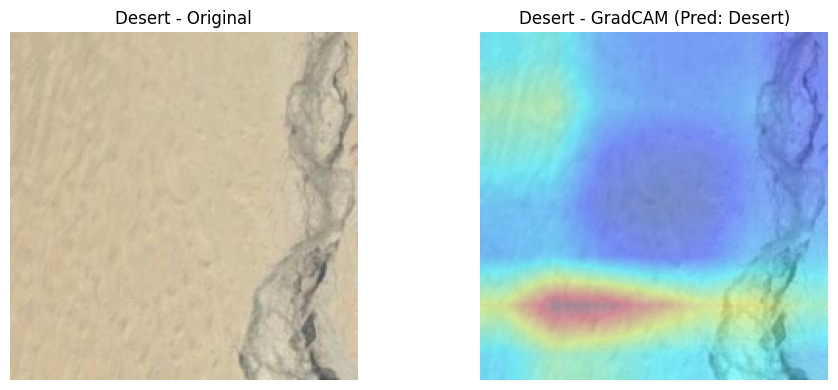

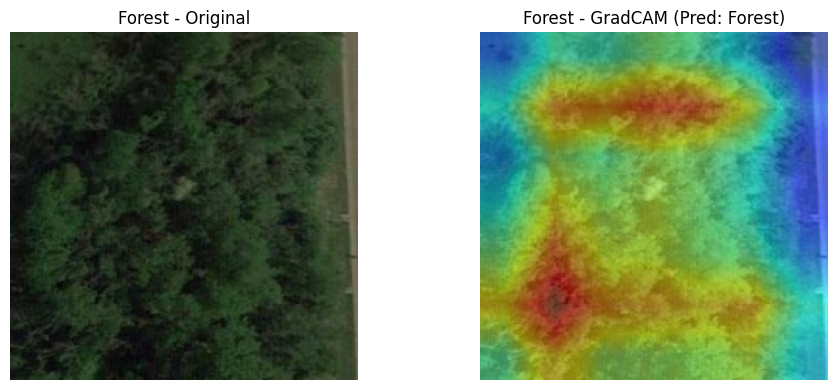

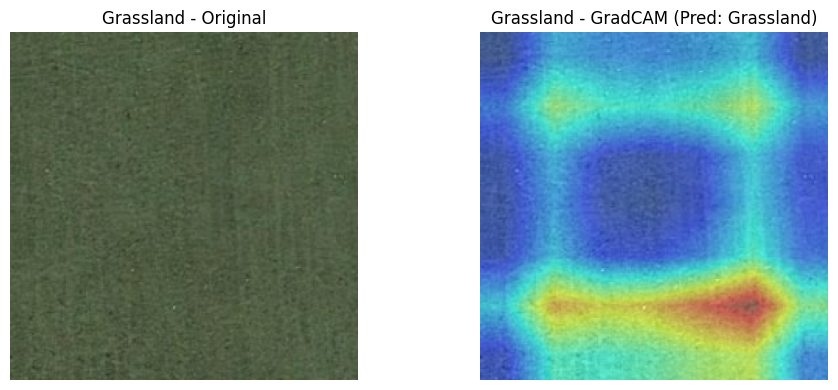

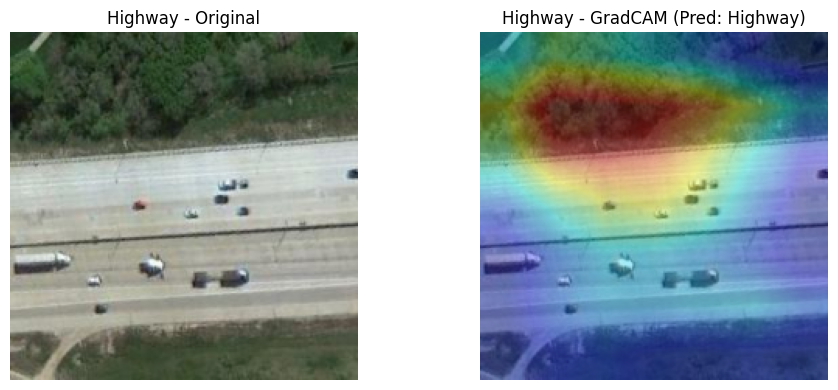

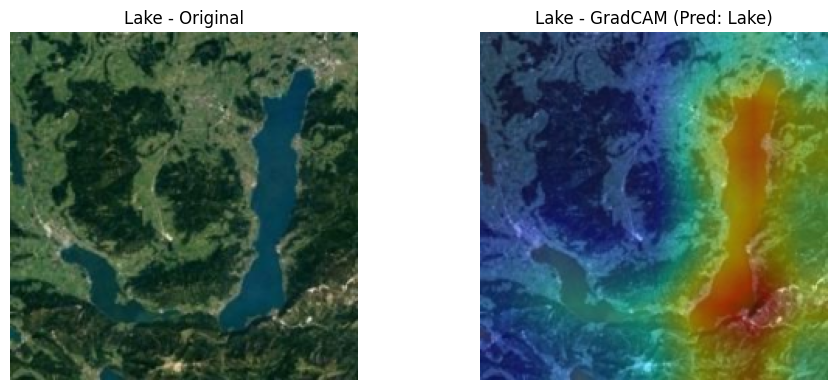

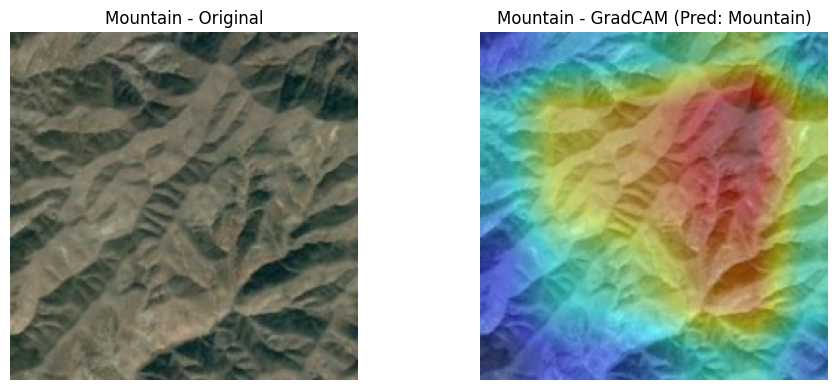

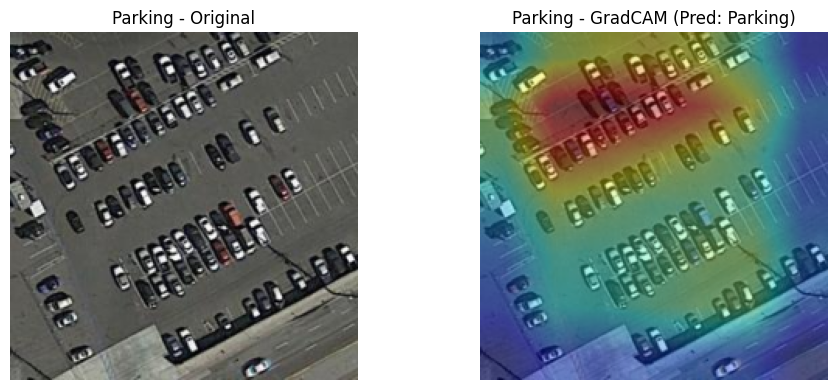

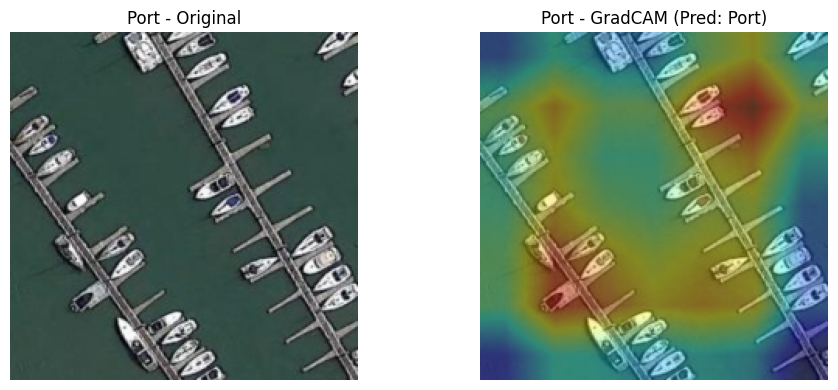

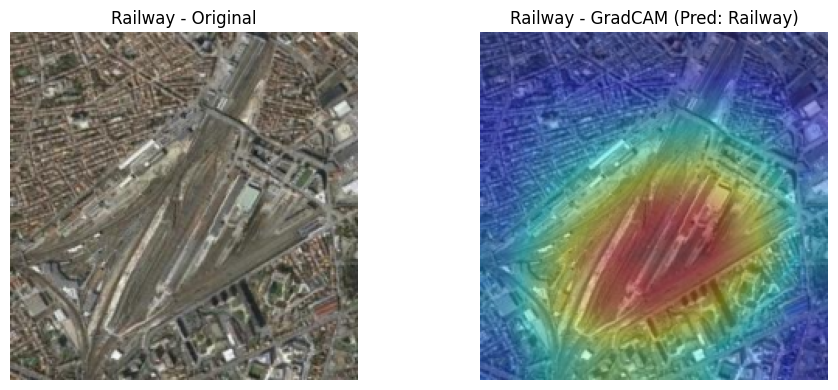

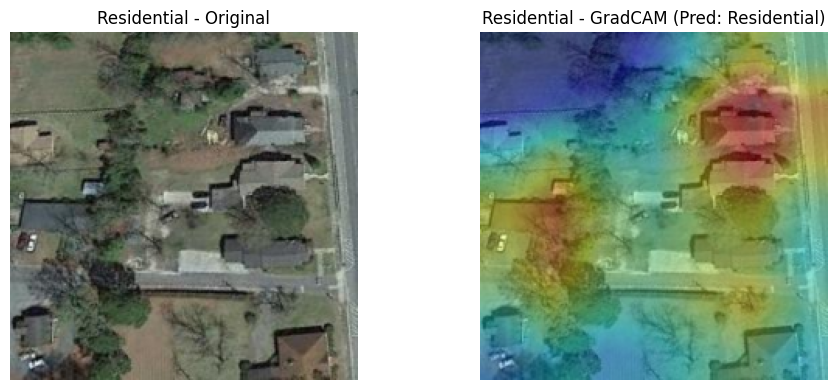

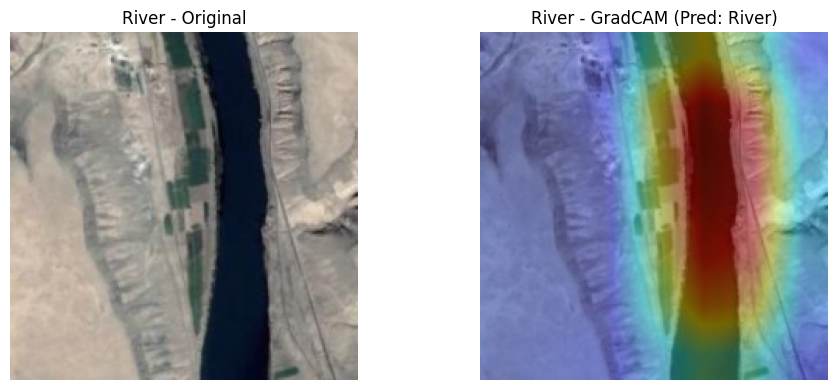

✅ 已为所有类别生成 Grad-CAM 可视化。


In [19]:
apply_gradcam_all_classes(model, device, test_loader, model_name="resnet")


## 🧪 模型鲁棒性对比评估：ResNet vs VGG

我们使用 `occluded_test_transform`（中心遮挡 + 归一化）对两个模型进行评估，比较它们在遮挡图像上的分类性能，包括：
- 准确率（Accuracy）
- 精确率 / 召回率 / F1 分数（Precision / Recall / F1-score）

通过这个实验可以观察不同架构的鲁棒性差异。


/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🔍 ResNet under Occlusion


/root/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

 Agriculture       0.00      0.00      0.00       160
     Airport       0.06      0.12      0.08       160
       Beach       0.00      0.00      0.00       160
        City       0.00      0.00      0.00       160
      Desert       0.05      0.07      0.06       160
      Forest       0.25      0.03      0.06       160
   Grassland       0.24      0.27      0.26       160
     Highway       0.00      0.00      0.00       160
        Lake       0.00      0.00      0.00       160
    Mountain       0.03      0.01      0.02       160
     Parking       0.25      0.01      0.02       160
        Port       0.00      0.00      0.00       160
     Railway       0.07      0.31      0.11       160
 Residential       0.04      0.18      0.06       160
       River       0.00      0.00      0.00       160

    accuracy                           0.07      2400
   macro avg       0.07      0.07      0.04      2400
weighted avg       0.07   

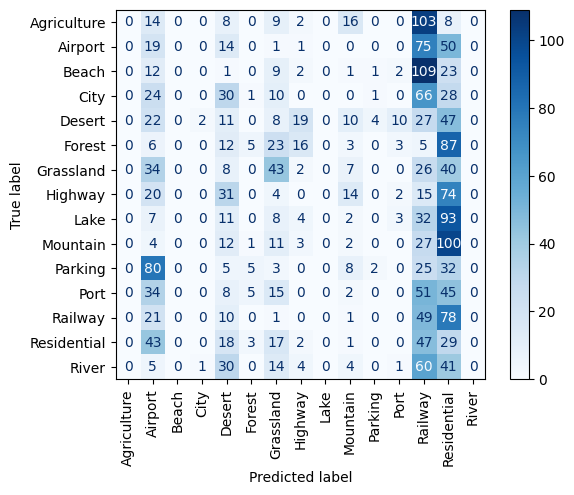

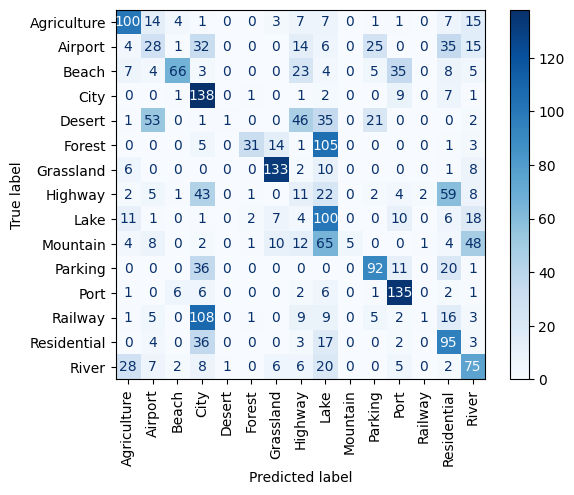

In [21]:
resnet_model = initialize_model("resnet", num_classes=len(classes))[0].to(device)
resnet_model.eval()
# ✅ 构建遮挡数据加载器
occluded_dataset = CustomDataset(test_images, test_labels, transform=occluded_test_transform)
occluded_loader = DataLoader(occluded_dataset, batch_size=32, shuffle=False)

# ✅ 对 ResNet 模型在遮挡数据上评估
print("🔍 ResNet under Occlusion")
evaluate_model(resnet_model, occluded_loader, device, class_names=classes)

# ✅ 对 VGG 模型在遮挡数据上评估
print("\n🔍 VGG under Occlusion")
evaluate_model(vgg_model, occluded_loader, device, class_names=classes)
